<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/main/AD_LTEM_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
# will be available once we get the approval
# !git clone https://github.com/danielzt12/AD_LTEM

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import signal as tfs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys, time
from scipy.fftpack import *
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
from scipy import ndimage
from google.colab import output
import tifffile as tif
import gdown

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla T4


In [2]:
# truth for amplitude and phase

# will be available once we get the approval
# true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
# true_phase = tif.imread('AD_LTEM/design_tphi.tiff')

!gdown "http://drive.google.com/uc?id=1H8wKBG_owtsM8pxwPq_O5a38omplenXk"
!gdown "http://drive.google.com/uc?id=12cyeYc_GNvfQ94IqyScxjtB08DZCwPGY"
true_amplitude =  tif.imread('design_amp.tiff')
true_phase = tif.imread('design_tphi.tiff')

true_phase -= true_phase.mean()

Downloading...
From: http://drive.google.com/uc?id=1H8wKBG_owtsM8pxwPq_O5a38omplenXk
To: /content/design_amp.tiff
100% 1.05M/1.05M [00:00<00:00, 69.1MB/s]
Downloading...
From: http://drive.google.com/uc?id=12cyeYc_GNvfQ94IqyScxjtB08DZCwPGY
To: /content/design_tphi.tiff
100% 1.05M/1.05M [00:00<00:00, 69.4MB/s]


In [3]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 14

defocus = np.linspace(-1.6e6,1.6e6,65)

!gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
A0 = np.load("amplitude4TIE_noise0.npy")

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise of the data set: {0:.1f}%".format((A_samples-A0).std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R
To: /content/amplitude4TIE_noise0.npy
136MB [00:01, 107MB/s] 
Downloading...
From: http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf
To: /content/amplitude4TIE_noise14.npy
136MB [00:01, 74.9MB/s]
estimated noise of the data set: 14.5%


Text(0.5, 1.0, '1600000.0 nm')

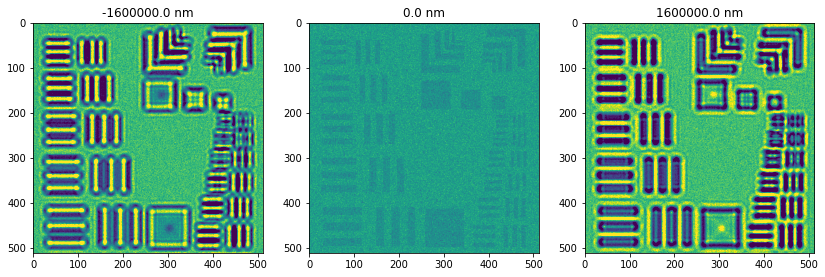

In [4]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

# AD Phase Retrieval

In [141]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 30

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")


Downloading...
From: http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca
To: /content/amplitude4TIE_noise30.npy
136MB [00:01, 84.2MB/s]


In [142]:
# generate microscopic transfer function

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)


Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 16.0MB/s]


In [143]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [144]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*TF)

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_phase,axis=-1))
  # lamb = 0 -> no TV regularization

  gerr = losses
  return losses


In [155]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    #if i>10:
    #  if np.abs(errs[-1]-errs[-2]) < tol or errs[-1]>errs[-2]:
    #    break

  return result_phase, np.array(errs), np.array(accs), i

In [156]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
#guess_amplitude = tf.constant(A_samples[32], dtype='float32') # used for noise free data
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [165]:
tot_errs = []
tot_accs = []

lr = 1
lamb = 0e-8 # no TV regularization
max_iter = 10000
t1=time.time()
result=optimize(1e-10,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 1259.2 s for 9999 iterations: 
final err 0.0193917378783226
final acc 0.877 
max acc 0.877 at iteration #7452: 


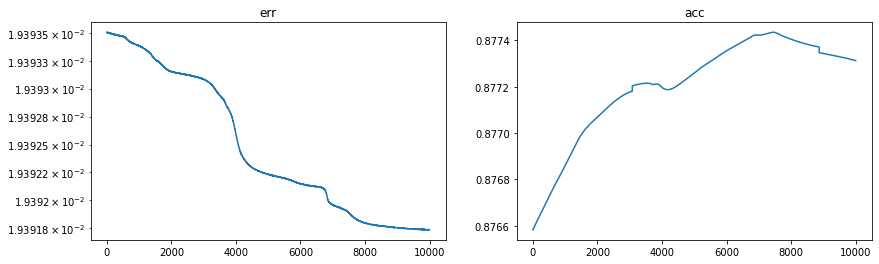

In [166]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");

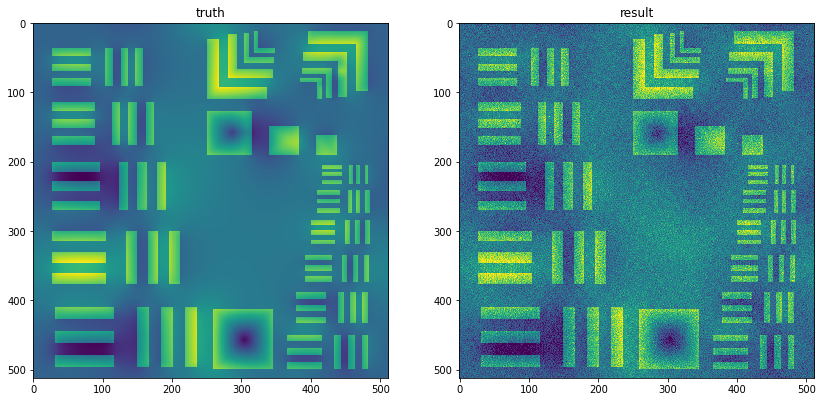

In [167]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

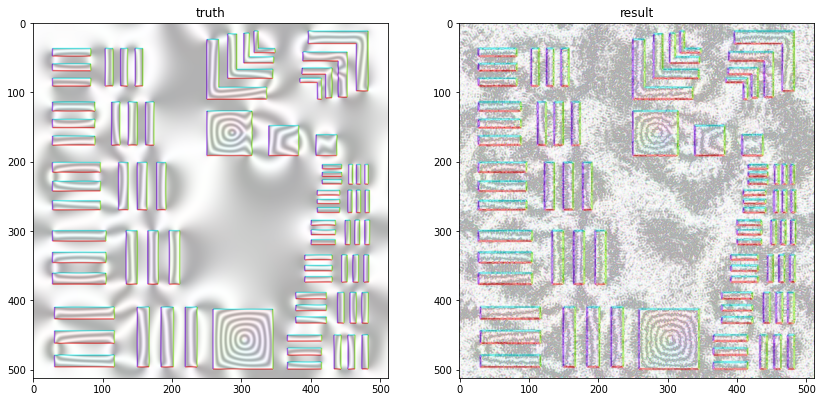

In [168]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

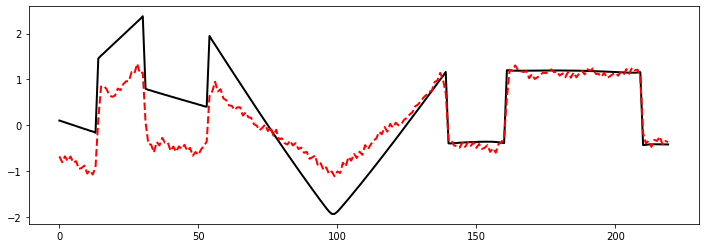

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)

ax.plot((result[0])[457,205:425], 'r--', linewidth=2)

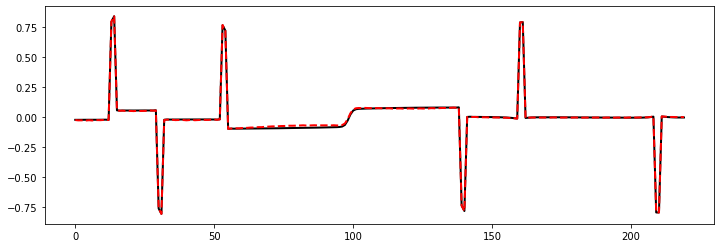

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.gradient(true_phase-true_phase.mean())[1][457,205:425], 'k-', linewidth=2)

ax.plot(np.gradient(result[0])[1][457,205:425], 'r--', linewidth=2)

# GS Phase Retrieval

In [217]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 30

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

Downloading...
From: http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca
To: /content/amplitude4TIE_noise30.npy
136MB [00:01, 114MB/s] 


In [218]:
# generate microscopic transfer function

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128) # the part without the damping envelop
DampEnvs = np.zeros(A_samples.shape, dtype=np.float64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  chiq = TEM.getChiQ(qq,del_px)
  tf_microscope[i] = np.cos(chiq) - 1j * np.sin(chiq)
  DampEnvs[i] =  TEM.getDampEnv(qq, del_px)

#A_samples /= A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 9.43MB/s]


In [219]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]
DE = fftshift(DampEnvs[selection], axes=(1,2))

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [220]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False)
# guess_amplitude = np.copy(A_samples[32])  # for noise free data
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(A_samples[32].shape)+0.5

In [ ]:
ObjWave = guess_amplitude * np.exp(1j*guess_phase)

acc = []
err = []

maxiter = 3000
t1 = time.time()
tol = 1e-10

t1 = time.time()

for i in range(maxiter):

  ImgWave = ifft2(fft2(ObjWave)*TF*DE)
  err.append(((np.abs(ImgWave)/np.abs(ImgWave).mean(1).mean(1)[:,np.newaxis,np.newaxis]-exp_data)**2).mean())
  ImgWave = ImgWave / np.abs(ImgWave) * exp_data
  #          ------  back propagation  -------  weighted sum with DE as weight (only works for small defocus)
  ObjWave = ifft2( (fft2(ImgWave)*np.conj(TF)).sum(0) / DE.sum(0) )
  result_phase = np.angle(ObjWave)
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  acc.append( (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum()) )
  if i>10:
    if np.abs(err[-1]-err[-2]) < tol or err[-1]>err[-2]:
      break
    if not i%100:
      print(err[-2]-err[-1], acc[-1])
  ObjWave = guess_amplitude * np.exp(1j*result_phase)

t2=time.time()
err = np.array(err)
acc = np.array(acc)

print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,i))
print("final err {0}".format(err[-1]))
print("final acc {0:.3f} ".format(acc[-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(acc.max(), acc.argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

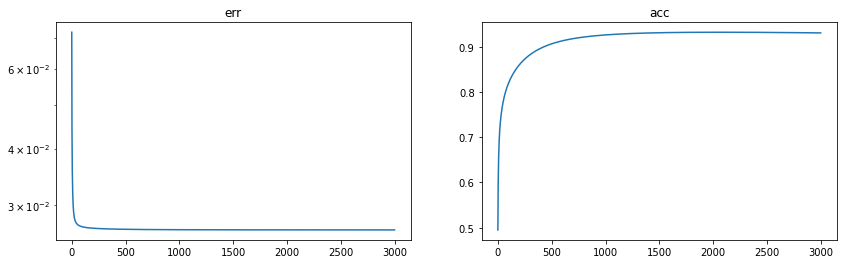

In [209]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(err)
ax[0].set_title("err")
ax[1].plot(acc)
ax[1].set_title("acc");

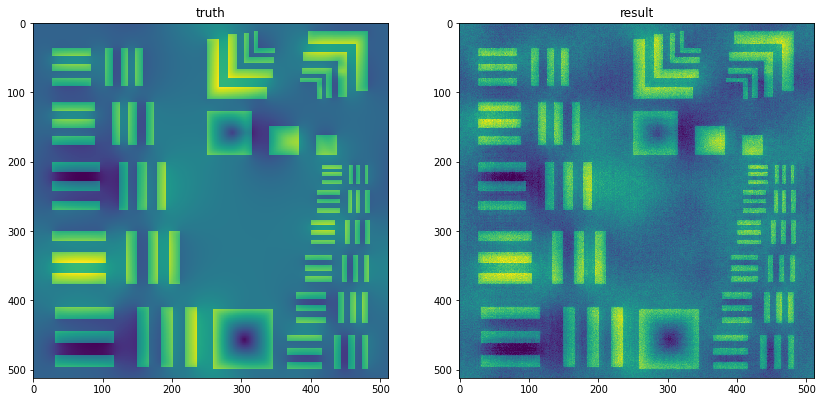

In [210]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

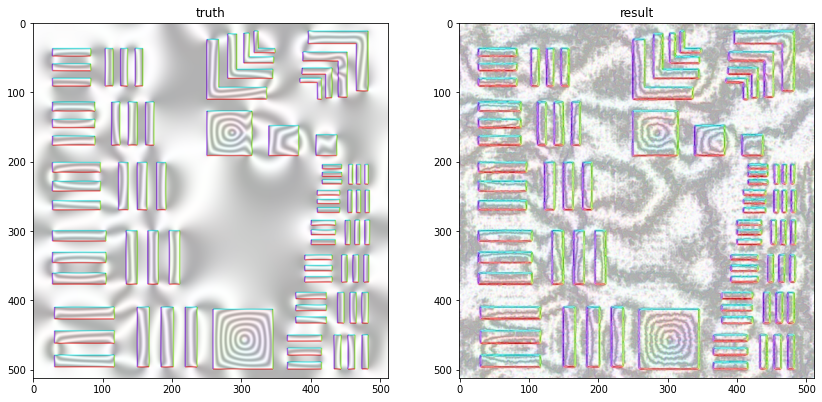

In [211]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

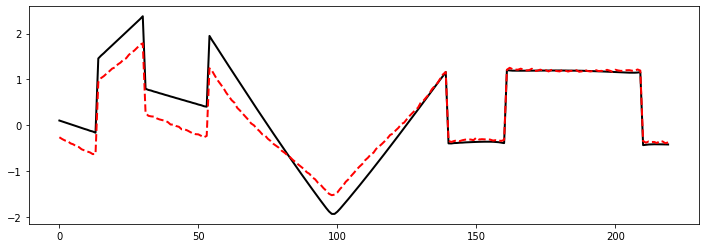

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)

ax.plot((result_phase)[457,205:425], 'r--', linewidth=2)

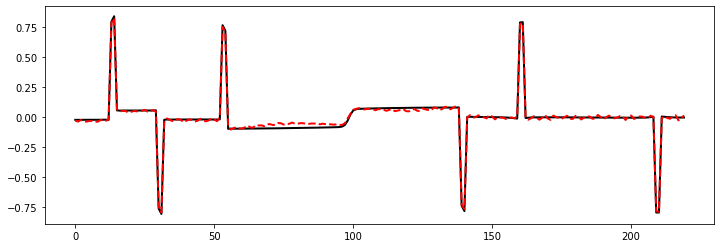

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.gradient(true_phase-true_phase.mean())[1][457,205:425], 'k-', linewidth=2)

ax.plot(np.gradient(result_phase)[1][457,205:425], 'r--', linewidth=2)

# Partial Probe Retrieval with AD

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 14

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf
To: /content/amplitude4TIE_noise14.npy
136MB [00:01, 133MB/s]
estimated noise from transparent region : 15.8%


In [ ]:
# rewriting the microscope transfer function with tensorflow

import scipy.constants as physcon

[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

del_px = 5 #nm/px

E = 200.0e3
Cs=1.0e6
Cc=5.0e6
Ca=0.0e6
phi_a=0
def_spr = 500

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

scale1 = 580
scale2 = 100

def getTF(defoc, theta_c, defoc_offset):

  # def_val = defoc / del_px
  #defoc_offset = tf.math.pow(10, defoc_offset)

  def_val = (defoc + defoc_offset * scale1) / del_px

  theta_c = tf.math.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
        
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = tf.math.multiply(1.0/u, tf.math.multiply(p5, (p6 * qq**3 - tf.math.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = tf.cast(tf.exp(es_arg-et_arg), tf.complex64)   # a tensor

  transfer_function = tfs.fftshift(tf.math.multiply(tf.complex(tf.cos(chiq),-tf.sin(chiq)), dampenv), axes=(1,2))

  return transfer_function

In [ ]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*getTF(defoc, theta_c, defoc_offset))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2)

  gerr = losses
  return losses


In [ ]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []
  theta_cs = []
  defoc_offsets = []
  theta_cs.append(float(theta_c))
  defoc_offsets.append(float(defoc_offset))

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    if i>50:
      train = opt.minimize(compute_loss, var_list=[guess_phase, theta_c, defoc_offset])
    else:
      train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    theta_cs.append(float(theta_c))
    defoc_offsets.append(float(defoc_offset))
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break
      if not i%100:
        print(errs[-2]-errs[-1], accs[-1], np.power(10,float(theta_c)/scale2), float(defoc_offset)*scale1/1000.)

  return result_phase, np.array(errs), np.array(accs), i, np.array(defoc_offsets)*scale1/1000., np.power(10,np.array(theta_cs)/100)

In [ ]:
selection = [28,30,62,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = A_samples[selection]

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
#guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
guess_amplitude = tf.constant(np.copy(A_samples[32]), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

defoc = tf.constant(defocus[selection][:, np.newaxis, np.newaxis]-1e4, dtype=tf.float32)
theta_c = tf.Variable(-400, dtype=tf.float32) #-500
defoc_offset = tf.Variable(0, dtype=tf.float32) #10

chosen defocus (mm):  [-0.2 -0.1  1.5  1.6]


In [ ]:
tot_errs = []
tot_accs = []

lr = 1
max_iter = 2500
t1=time.time()
result=optimize(1e-9,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

0.00084280036 0.6959388630889739 3.202977545451723e-05 16.583102798461915
3.2288954e-06 0.8310653782656069 1.0751357865860639e-05 13.14427677154541
8.4377825e-07 0.8563736018232125 1.0722755330988992e-05 12.42878288269043
5.3923577e-07 0.8708922562259537 1.074180515599147e-05 11.993422241210938
4.02797e-07 0.8815507918216733 1.0754788340406544e-05 11.67205307006836
3.1851232e-07 0.8900152502642596 1.0762287812088233e-05 11.42335205078125
2.6728958e-07 0.8969951363928621 1.0766357252807105e-05 11.222546653747559
2.2817403e-07 0.9028621223874832 1.0769096292644995e-05 11.055024261474609
1.9883737e-07 0.9078790191400716 1.0770942889418129e-05 10.913480224609375
1.7788261e-07 0.9122258661416317 1.0772078249509223e-05 10.7910147857666
1.6251579e-07 0.9160242443188793 1.0772873072780509e-05 10.682490463256835
1.4854595e-07 0.9193636981241825 1.0773675525284162e-05 10.585396041870117
1.3550743e-07 0.9223187540000775 1.077459160544713e-05 10.49886531829834
1.2246892e-07 0.924956523825822 1.077

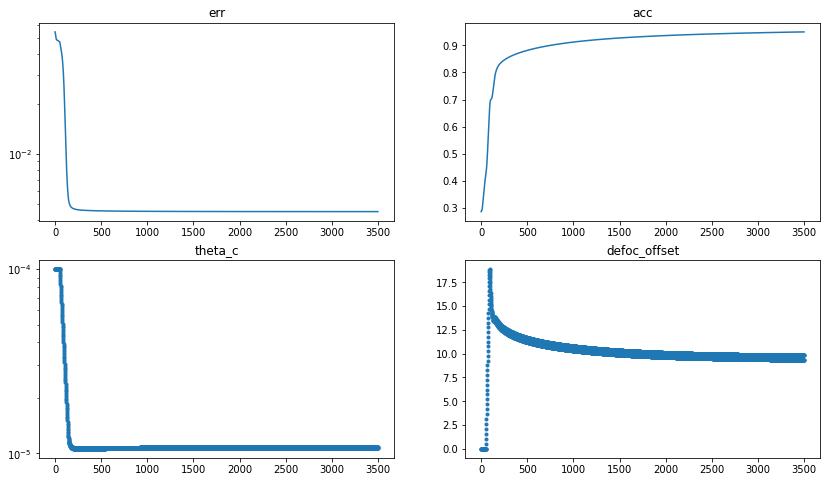

In [ ]:
f, ax = plt.subplots(ncols=2, nrows=2, figsize = (14,8))
ax[0,0].semilogy(result[1])
ax[0,0].set_title("err")
ax[0,1].plot(result[2])
ax[0,1].set_title("acc");
ax[1,0].semilogy(result[-1], '.')
ax[1,0].set_title("theta_c");
ax[1,1].plot(result[-2], '.')
ax[1,1].set_title("defoc_offset");

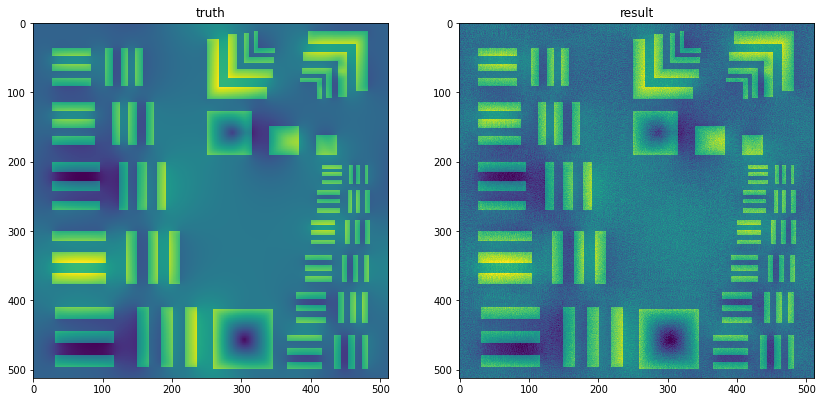

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

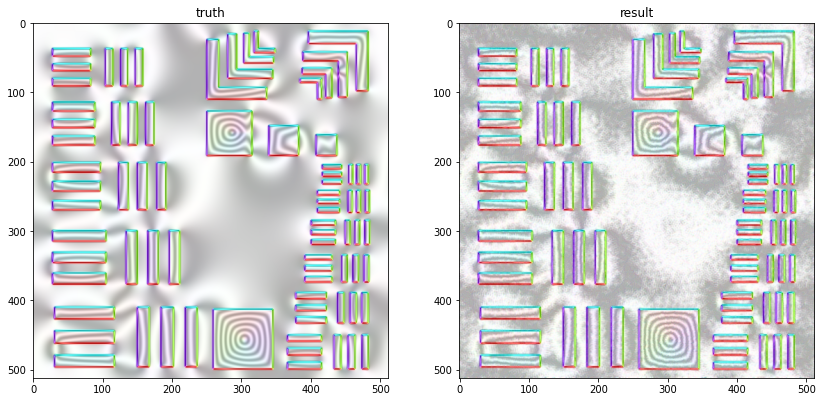

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

# Saving

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'

In [212]:
np.save(path+"0_29_35_64_GS_noise30_err.npy", err)
np.save(path+"0_29_35_64_GS_noise30_acc.npy", acc)
np.save(path+"0_29_35_64_GS_noise30_pha.npy", result_phase)

In [164]:
np.save(path+"0_29_35_64_AD_noise30_err_1.npy", result[1])
np.save(path+"0_29_35_64_AD_noise30_acc_1.npy", result[2])
np.save(path+"0_29_35_64_AD_noise30_pha_1.npy", result[0])

In [ ]:
np.save(path+"28_30_62_64_AD_14_TF_scale580_err.npy", result[1])
np.save(path+"28_30_62_64_AD_14_TF_scale580_acc.npy", result[2])
np.save(path+"28_30_62_64_Ad_14_TF_scale580_pha.npy", result[0])
np.save(path+"28_30_62_64_Ad_14_TF_scale580_par1.npy", result[4])
np.save(path+"28_30_62_64_Ad_14_TF_scale580_par2.npy", result[5])

(-3.0, 2.6)


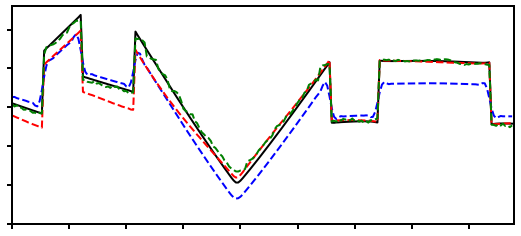

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)

ttt = tif.imread("/content/drive/My Drive/new_test_data_for_ADLorentz/res_test_pattern/new_TIE_recons/"+"Stack_nonoise_olddef_tphi-1.tif")[::-1]
ttt -= ttt.mean()
ax.plot((ttt)[457,205:425], 'b--', linewidth=2)

ttt = np.load('/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'+'29_35_AD_0_1em10_pha.npy')
ttt -= ttt.mean()
ax.plot((ttt)[457,205:425], 'r--', linewidth=2)



ttt = np.load('/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'+'0_64_Ad_10_1em10_TV4em8_pha.npy')
#ttt = np.load('/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'+'29_35_GS_0_1em10_pha.npy')
ttt -= ttt.mean()
ax.plot((ttt)[457,205:425], 'g--', linewidth=2)

ax.set_xlim(0, 220)
ax.set_ylim(-3, 2.6)
ax.set_xticklabels([])
ax.set_yticklabels([])
print(ax.get_ylim())

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
  
ax.tick_params(which='major',width=2, length=5)

#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"figS2_compare_cut.png", dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

(-3.0, 2.6)


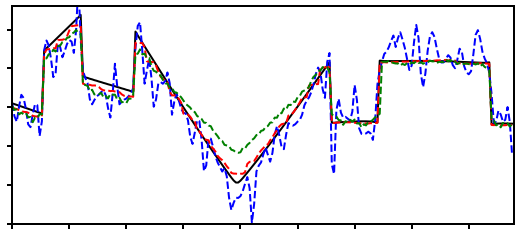

In [118]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)


ttt = np.load(path+"0_64_AD_noise10_TV0em8_LR0p2_pha.npy")
ttt -= ttt.mean()
ax.plot((ttt)[457,205:425], 'b--', linewidth=2)

ttt = np.load(path+"0_64_AD_noise10_TV4em8_LR0p2_pha.npy")
ttt -= ttt.mean()
ax.plot((ttt)[457,205:425], 'r--', linewidth=2)



ttt = np.load(path+"0_64_AD_noise10_TV4em7_LR0p2_pha.npy")
#ttt = np.load('/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'+'29_35_GS_0_1em10_pha.npy')
ttt -= ttt.mean()
ax.plot((ttt)[457,205:425], 'g--', linewidth=2)

ax.set_xlim(0, 220)
ax.set_ylim(-3, 2.6)
ax.set_xticklabels([])
ax.set_yticklabels([])
print(ax.get_ylim())

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
  
ax.tick_params(which='major',width=2, length=5)

#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"figS2_compare_cut.png", dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

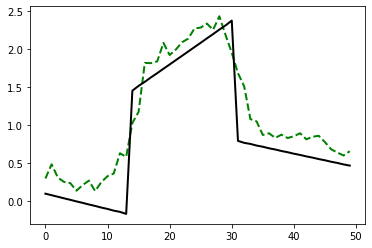

In [ ]:
ttt = np.load('/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'+'0_64_GS_0_1em10_pha.npy')
ttt -= ttt.mean()
plt.plot((ttt)[457,205:255], 'g--', linewidth=2)
plt.plot((true_phase-true_phase.mean())[457,205:255], 'k-', linewidth=2)


(0.5, 1.0)
0.8606337638025107 0.9899722111087554 0.9672251907387126


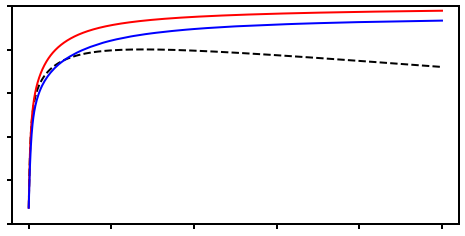

In [121]:
e1 = np.load(path+"0_64_AD_noise10_TV0em8_LR0p2_acc.npy")
e2 = np.load(path+"0_64_AD_noise10_TV4em8_LR0p2_acc.npy")
e3 = np.load(path+"0_64_AD_noise10_TV4em7_LR0p2_acc.npy")
#e4 = np.load(path+"28_30_62_64_AD_14_1em9_acc.npy")

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(e1, "k--", linewidth = 2)
ax.plot(e2, "r", linewidth = 2)
ax.plot(e3, "b", linewidth = 2)
#ax.plot(e4, "r", linewidth = 2)

ax.set_xlim(-200, 5200)
ax.set_ylim(0.5, 1)
ax.set_xticklabels([])
ax.set_yticklabels([])
print(ax.get_ylim())

print(e1[-1], e2[-1], e3[-1])

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
  
ax.tick_params(which='major',width=2, length=5)

#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"figs3_acc.png", dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

(0.0020570566725099295, 0.07679535498504174)


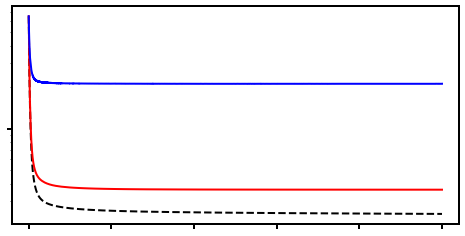

In [106]:
e1 = np.load(path+"0_64_AD_noise10_TV0em8_LR0p2_err.npy")
e2 = np.load(path+"0_64_AD_noise10_TV4em8_LR0p2_err.npy")
e3 = np.load(path+"0_64_AD_noise10_TV4em7_LR0p2_err.npy")
#e4 = np.load(path+"28_30_62_64_AD_14_1em9_acc.npy")

fig, ax = plt.subplots(figsize=(8,4))
ax.semilogy(e1, "k--", linewidth = 2)
ax.semilogy(e2, "r", linewidth = 2)
ax.semilogy(e3, "b", linewidth = 2)
#ax.plot(e4, "r", linewidth = 2)

ax.set_xlim(-200, 5200)
#ax.set_ylim(0.5, 1)
ax.set_xticklabels([])
ax.set_yticklabels([])
print(ax.get_ylim())


for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
  
ax.tick_params(which='major',width=2, length=5)

plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"figs3_err.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

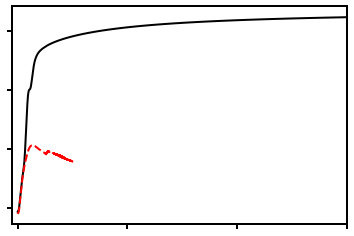

In [ ]:
acc1 = np.load(path+"28_30_62_64_AD_14_nTF_acc.npy")
acc2 = np.load(path+"28_30_62_64_AD_14_TF_scale580_acc.npy")


fig, ax = plt.subplots(figsize=(6,4))
ax.plot(acc2, "k", linewidth = 2)
ax.plot(acc1[:500], "r--", linewidth = 2)

ax.set_xlim(-50, 2500)
#ax.set_ylim(0.2, 1)
ax.set_xticks(np.arange(0,3010,1000))
ax.set_yticks([0.3,0.5,0.7,0.9])
ax.set_yticklabels([])
ax.set_xticklabels([])

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
  
ax.tick_params(which='major',width=2, length=5)

plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"fig6_acc1.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

In [ ]:
print(acc2[2500])

0.9422534155728645


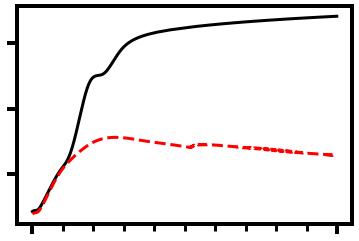

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

acc1 = np.load(path+"28_30_62_64_AD_14_nTF_acc.npy")
acc2 = np.load(path+"28_30_62_64_AD_14_TF_scale580_acc.npy")


fig, ax = plt.subplots(figsize=(6,4))
ax.plot(acc2[:500], "k", linewidth = 3)
ax.plot(acc1[:500], "r--", linewidth = 3)
#ax.plot(acc2[:500], "k", linewidth = 2)

#ax.set_xlim(-50, 3700)
#ax.set_ylim(0.2, 1)
#ax.set_xticks(np.arange(0,510,500))
#ax.set_xticks(np.arange(0,510,500))
ax.set_yticks([0.4,0.6,0.8])
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_yticklabels([])
ax.set_xticklabels([])

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(4)
  
ax.tick_params(which='major',width=4, length=10)
ax.tick_params(which='minor',width=3, length=7)

plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"fig6_acc2.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

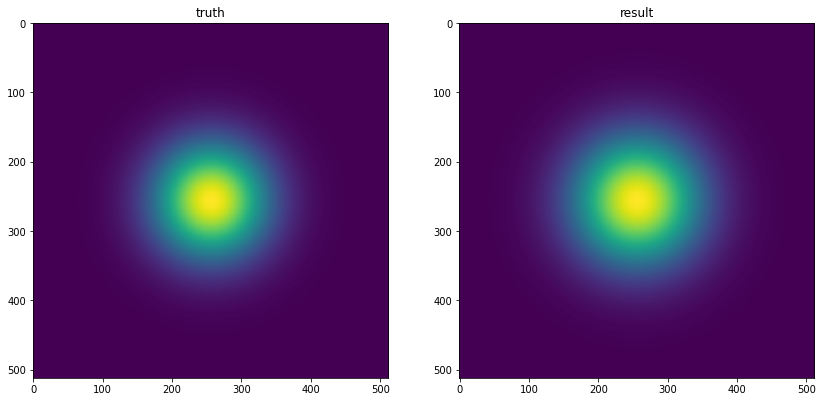

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(np.abs(t0), interpolation='none', norm=colors.Normalize(np.abs(t0).min(), np.abs(t0).max()))
ax[0].set_title("truth")
ax[1].imshow(np.abs(tt), interpolation='none', norm=colors.Normalize(np.abs(t0).min(), np.abs(t0).max()))
ax[1].set_title("result");

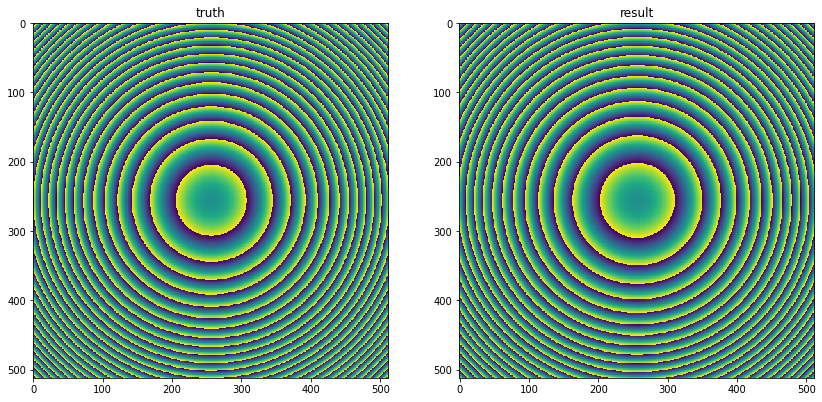

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(np.angle(t0), interpolation='none', norm=colors.Normalize(np.angle(t0).min(), np.angle(t0).max()))
ax[0].set_title("truth")
ax[1].imshow(np.angle(tt), interpolation='none', norm=colors.Normalize(np.angle(t0).min(), np.angle(t0).max()))
ax[1].set_title("result");

(2665,) 0.8727962475918515
2.891621976214028 -2.327420682591819


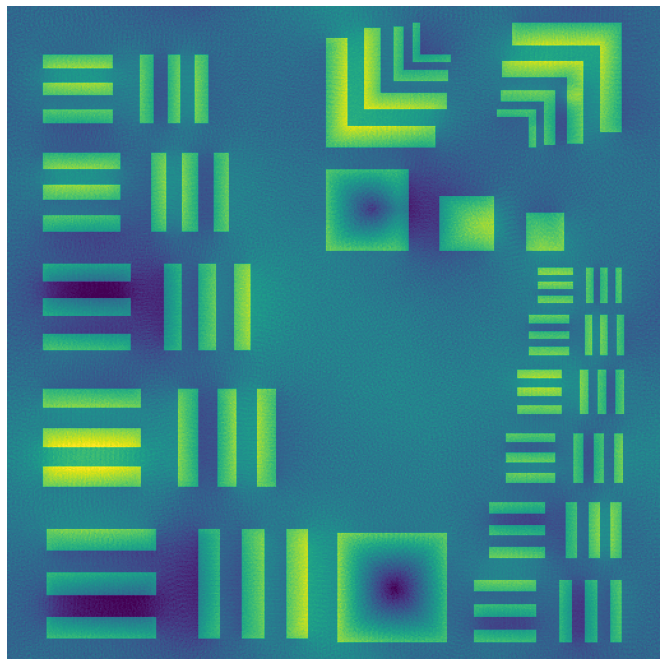

In [178]:
tt = np.load(path+"0_29_35_64_AD_noise15_pha.npy")
acc =  np.load(path+"0_29_35_64_AD_noise30_acc.npy")
print(acc.shape, acc[-1])

f, ax = plt.subplots(figsize=(12,12))
ax.imshow(tt-tt.mean(), vmin=-2.12, vmax=2.67)#, interpolation='none')
print((tt-tt.mean()).max(), (tt-tt.mean()).min())
ax.set_axis_off()

plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"phase_0_29_35_64_AD_noise15.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

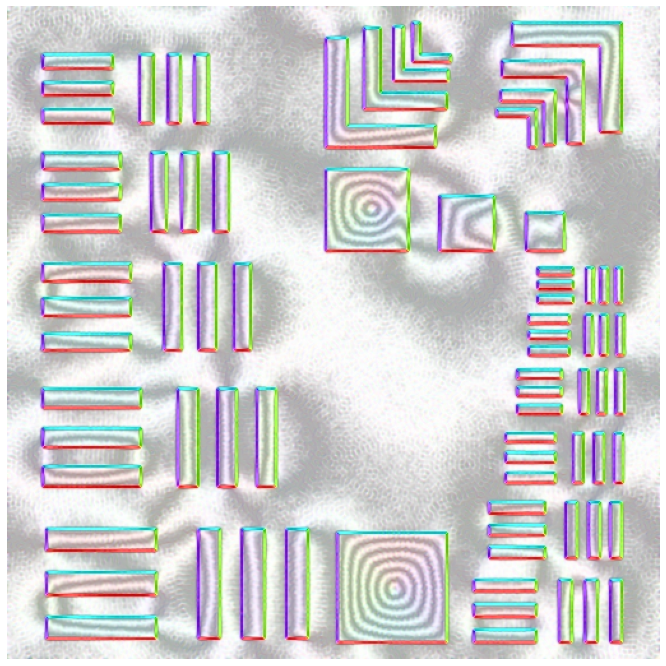

In [179]:
f, ax = plt.subplots(figsize = (12,12))

t2=ndimage.gaussian_filter(tt-np.mean(tt),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax.imshow(rgb_map)
ax.imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax.set_axis_off()
plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"gradient_0_29_35_64_AD_noise15.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

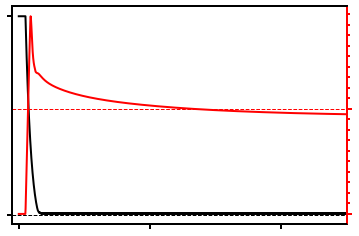

In [ ]:
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

p1 = np.load(path+"28_30_62_64_Ad_14_TF_scale580_par1.npy")
p2 = np.load(path+"28_30_62_64_Ad_14_TF_scale580_par2.npy")

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(p2, "k", linewidth = 2)
ax1.axhline(1e-5, color="k", linewidth = 1, linestyle='--')

ax2 = ax1.twinx()  
ax2.plot(np.arange(3501)[::2],p1[::2], "r", linewidth = 2)
ax2.axhline(10, color="r", linewidth = 1, linestyle='--')
ax2.tick_params(axis='y', labelcolor='r', color='r')
#ax.plot(acc2[:500], "k", linewidth = 2)
ax1.set_yticks([1e-5,1e-4])
ax1.set_xlim(-50, 2500)
#ax.set_ylim(0.2, 1)
ax1.set_xticks(np.arange(0,2510,1000))

#ax2.set_yticks([0,10])
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.spines['right'].set_color('r')
ax2.spines["right"].set_color('r')
  
ax1.tick_params(which='major',width=2, length=5)
ax1.tick_params(which='minor',width=2, length=3)
ax2.tick_params(which='major',width=2, length=5)
ax2.tick_params(which='minor',width=2, length=3, color='r')

plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/"+"fig6_par.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

In [ ]:
print((p2[-1]-1e-5)*1e6)

0.6619866588776678


In [ ]:
#noise = B_samples-np.random.normal(B_samples,0.01)

In [ ]:
noise1000 = np.copy(noise)

In [ ]:
noise=0

In [ ]:
# generate microscopic transfer function

from microscopes_fwd import Microscope

defocus = np.linspace(0,1e6,5)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros((5, 512, 512), dtype=np.complex128)
DampEnvs = np.zeros((5, 512, 512), dtype=np.float64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
  DampEnvs[i] =  TEM.getDampEnv(qq, del_px)

TF = fftshift(tf_microscope/DampEnvs, axes=(1,2))
DE = fftshift(DampEnvs, axes=(1,2))

print(defocus)

[      0.  250000.  500000.  750000. 1000000.]


In [ ]:
B_samples = np.abs(ifft2(fft2(true_amplitude*np.exp(1j*true_phase))*TF*DE))
B_samples/=B_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

In [ ]:
#B_samples = B_samples + noise1000*0
#B_samples[B_samples<0]=0

In [ ]:
exp_data = np.copy(B_samples[1:])

In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
# guess_amplitude = denoise_tv_chambolle(B_samples[0], weight=noise/100./2, multichannel=False)
guess_amplitude = np.copy(B_samples[0])
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(B_samples[0].shape)+0.5

In [ ]:
ObjWave = guess_amplitude * np.exp(1j*guess_phase)

acc = []
err = []

maxiter = 3000
t1 = time.time()
tol = 1e-9

t1 = time.time()

for i in range(maxiter):

  ImgWave = ifft2(fft2(ObjWave)*TF[1:]*DE[1:])
  err.append(((np.abs(ImgWave)/np.abs(ImgWave).mean(1).mean(1)[:,np.newaxis,np.newaxis]-exp_data)**2).mean())
  ImgWave = ImgWave / np.abs(ImgWave) * exp_data
  #          ------  back propagation  -------  weighted sum with DE as weight (only works for small defocus)
  ObjWave = ifft2( (fft2(ImgWave)*np.conj(TF[1:])).sum(0) / DE[1:].sum(0) )
  result_phase = np.angle(ObjWave)
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  acc.append( (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum()) )
  if i>10:
    #if np.abs(err[-1]-err[-2]) < tol or err[-1]>err[-2]:
    #  break
    if not i%100:
      print(err[-2]-err[-1], acc[-1])
  ObjWave = guess_amplitude * np.exp(1j*result_phase)

t2=time.time()
err = np.array(err)
acc = np.array(acc)

print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,i))
print("final err {0}".format(err[-1]))
print("final acc {0:.3f} ".format(acc[-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(acc.max(), acc.argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

4.320171856132772e-06 0.762203392093594
8.742206187276242e-07 0.8099476380122096
3.5465136984153174e-07 0.8356958951865563
1.940828978769227e-07 0.8535636876925587
1.2673495681969258e-07 0.8673369719134815
9.117749386827279e-08 0.8784752352220859
6.937248303278944e-08 0.8877296950199347
5.4700257034917305e-08 0.8955633620220432
4.421391273576585e-08 0.9022894194394602
3.640497328895038e-08 0.908131470544073
3.0418525667455954e-08 0.9132549156073828
2.572796677459261e-08 0.9177852617411347
2.1988504438262232e-08 0.921819648068152
1.8964118249522157e-08 0.9254344957129668
1.6487597910569288e-08 0.9286907837230596
1.4437338378450027e-08 0.9316377908183631
1.2723091103692834e-08 0.934315805724507
1.1276786315750662e-08 0.9367581232554989
1.0046389182925597e-08 0.938992534601446
8.991660024882509e-09 0.9410424531977467
8.08115802278055e-09 0.9429277743776557
7.290083621804813e-09 0.9446655382874614
6.598701332853792e-09 0.9462704459408837
5.99117248578968e-09 0.9477552646434309
5.4546823246

# Experimental Data

In [ ]:
!pip install fabio
import fabio
from scipy.signal import fftconvolve

In [ ]:
!gdown "http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54"
expdata = fabio.open("FS4_restest_q_10mu_1s_alimj_crp.tif")

#!gdown "http://drive.google.com/uc?id=1kgxxrJzQgxO2xRGsVoVmwWD7F8J3fgA3"
# expdata = fabio.open("FS3_restest_q_10mu_0.2s_alimj_crp.tif")

Downloading...
From: http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54
To: /content/FS4_restest_q_10mu_1s_alimj_crp.tif
105MB [00:00, 158MB/s]  


In [ ]:
def cross_correlation(im1, im2):
  im1_2 = im1 - im1.mean()
  im2_2 = im2 - im2.mean()
  ccl = fftconvolve(im1_2, im2_2[::-1,::-1], mode='same')
  dy, dx = np.unravel_index(np.argmax(ccl), im2.shape)
  dy -= im2.shape[0]/2.
  dx -= im2.shape[1]/2.
  return (int(dy), int(dx))

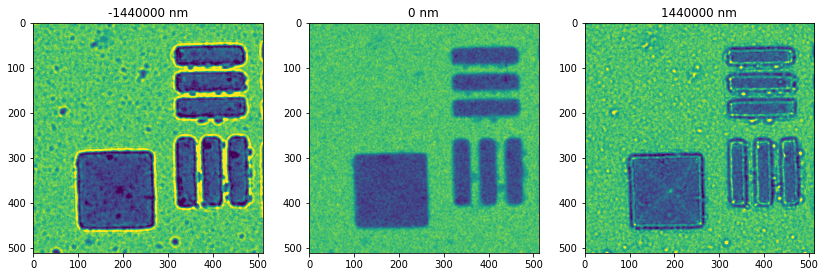

In [ ]:
A_samples = np.zeros((25,512,512))

A_mid = expdata.getframe(12).data[185:697,:512][480-256:480,300-256:300]

for i in range(25):
  A_now = expdata.getframe(i).data[185:697,:512][480-256:480,300-256:300]
  dy, dx = cross_correlation(A_now , A_mid)
  A_now = expdata.getframe(i).data[185:697,:512][480-256+dy:480+dy,300-256+dx:300+dx]
  dy2, dx2 = cross_correlation(A_now , A_mid)
  #print(dy, dx, dy2, dx2)
  if dx>=0:
    A_samples[i] =  expdata.getframe(i).data[185+dy:697+dy,dx:512+dx]
  else:
    A_samples[i,:,dx:] =  expdata.getframe(i).data[185+dy:697+dy,dx:512]

  #A_samples[i] =  expdata.getframe(i).data[185-44:697-44,:512] #2s
  #A_samples[i] =  expdata.getframe(i).data[185:697,:512] #0p2s
  A_samples[i] =  expdata.getframe(i).data[185-13:697-13,:512] #1s

A_samples = np.sqrt(A_samples)
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

defocus = np.array([-1440000,-1210000,-1000000,-810000,-640000,-490000,-360000,-250000,-160000,-90000,-40000,-10000,0,\
                      10000,40000,90000,160000,250000,360000,490000,640000,810000,1000000,1210000,1440000])

f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[12], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[1].set_title("{0} nm".format(defocus[12]))
ax[2].imshow(A_samples[24], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[2].set_title("{0} nm".format(defocus[24]));

In [ ]:
# rewriting the microscope transfer function with tensorflow

import scipy.constants as physcon

[dim,dim] = A_samples[12].shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

del_px = 6.9 #nm/px

E = 200.0e3
Cs=1.0e6
Cc=5.0e6
Ca=0.0e6
phi_a=0
def_spr = 500

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

scale1 = 1
scale2 = 100

def getTF(defoc, theta_c):

  # def_val = defoc / del_px
  #defoc_offset = tf.math.pow(10, defoc_offset)

  def_val = defoc * scale1 / del_px

  theta_c = tf.math.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
        
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = tf.math.multiply(1.0/u, tf.math.multiply(p5, (p6 * qq**3 - tf.math.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = tf.cast(tf.exp(es_arg-et_arg), tf.complex64)   # a tensor

  transfer_function = tfs.fftshift(tf.math.multiply(tf.complex(tf.cos(chiq),-tf.sin(chiq)), dampenv), axes=(1,2))

  return transfer_function

In [ ]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*getTF(defoc, theta_c))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_phase,axis=-1))

  gerr = losses
  return losses


In [ ]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  theta_cs = []
  defocs = []
  theta_cs.append(float(theta_c))

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    #if i>50:
    #  train = opt.minimize(compute_loss, var_list=[guess_phase, defoc])
    #else:
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    theta_cs.append(float(theta_c))
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    errs.append(gerr.numpy())
    if i>10:
      #if np.abs(errs[-1]-errs[-2]) < tol:
      #  break
      if not i%100:
        print(errs[-2]-errs[-1])#, np.power(10,float(theta_c)/scale2), defoc.numpy()[:,0,0]*scale1/1e6)

  return result_phase, np.array(errs), i, np.array(defocs), np.power(10,np.array(theta_cs)/100)

In [ ]:
#selection = [4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24]
selection = [8,9,23,24]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = A_samples[selection]

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False), dtype='float32')
#guess_amplitude = tf.constant(np.copy(A_samples[12]), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[12].shape)+0.5, dtype='float32') 
#guess_phase = tf.Variable(result[0], dtype='float32') 

defoc = tf.constant(defocus[selection][:, np.newaxis, np.newaxis]/scale1, dtype=tf.float32)
theta_c = tf.constant(-500, dtype=tf.float32) 

chosen defocus (mm):  [-0.16 -0.09  1.21  1.44]


In [ ]:
tot_errs = []
lr = 1
lamb = 0e-9
max_iter = 10000
for iii in range(10):
  t1=time.time()
  result=optimize(1e-9,max_iter=max_iter,lr=lr)
  t2=time.time()
  print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[2]))
  print("final err {0}".format(result[1][-1]))
  np.save(path+"exp_new_{0}.npy".format(iii), result[0])

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

9.430805e-07
3.669411e-07
1.8911669e-07
1.15367584e-07
7.910421e-08
5.873153e-08
4.6100467e-08
3.7718564e-08
3.1664968e-08
2.73576e-08
2.415618e-08
2.1536835e-08
1.9266736e-08
1.7229468e-08
1.5890691e-08
1.4319085e-08
1.3329554e-08
1.22818165e-08
1.1292286e-08
1.0593794e-08
1.0011718e-08
9.19681e-09
8.6729415e-09
8.090865e-09
7.508788e-09
7.21775e-09
6.693881e-09
6.2864274e-09
6.0535967e-09
5.529728e-09
5.4133125e-09
5.296897e-09
5.005859e-09
4.8894435e-09
4.656613e-09
4.3655746e-09
4.1909516e-09
3.8999133e-09
3.783498e-09
3.8417056e-09
3.608875e-09
3.4924597e-09
3.3178367e-09
3.3178367e-09
3.085006e-09
3.085006e-09
3.0267984e-09
2.8521754e-09
2.910383e-09
2.7939677e-09
2.6775524e-09
2.8521754e-09
2.561137e-09
2.5029294e-09
2.561137e-09
2.3283064e-09
2.2700988e-09
2.3283064e-09
2.2118911e-09
2.3283064e-09
2.2118911e-09
2.1536835e-09
2.2118911e-09
2.0954758e-09
2.0954758e-09
2.0372681e-09
1.8626451e-09
1.8626451e-09
1.9790605e-09
1.8626451e-09
1.7462298e-09
1.7462298e-09
1.9790605e-09
1

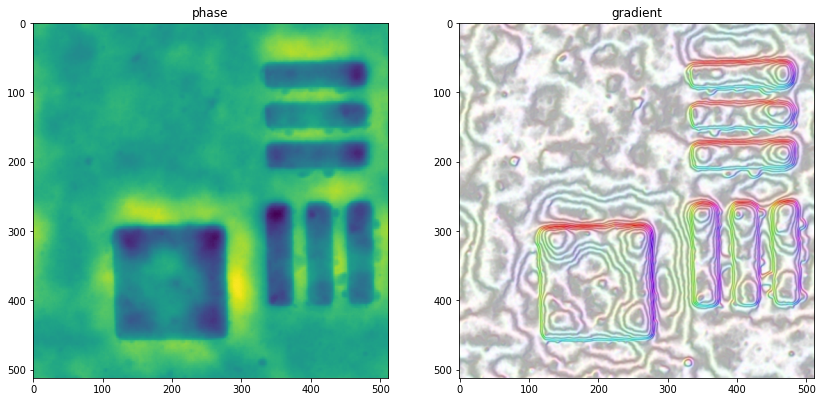

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

ax[0].imshow(result[0], interpolation='none', cmap='viridis')
ax[0].set_title("phase")

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap='gray', alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("gradient");

# EXP GS


In [ ]:
!pip install fabio
import fabio
from scipy.signal import fftconvolve
!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 16.5MB/s]


In [ ]:
!gdown "http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54"
expdata = fabio.open("FS4_restest_q_10mu_1s_alimj_crp.tif")

#!gdown "http://drive.google.com/uc?id=1kgxxrJzQgxO2xRGsVoVmwWD7F8J3fgA3"
#expdata = fabio.open("FS3_restest_q_10mu_0.2s_alimj_crp.tif")

Downloading...
From: http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54
To: /content/FS4_restest_q_10mu_1s_alimj_crp.tif
105MB [00:00, 158MB/s]  


In [ ]:
def cross_correlation(im1, im2):
  im1_2 = im1 - im1.mean()
  im2_2 = im2 - im2.mean()
  ccl = fftconvolve(im1_2, im2_2[::-1,::-1], mode='same')
  dy, dx = np.unravel_index(np.argmax(ccl), im2.shape)
  dy -= im2.shape[0]/2.
  dx -= im2.shape[1]/2.
  return (int(dy), int(dx))

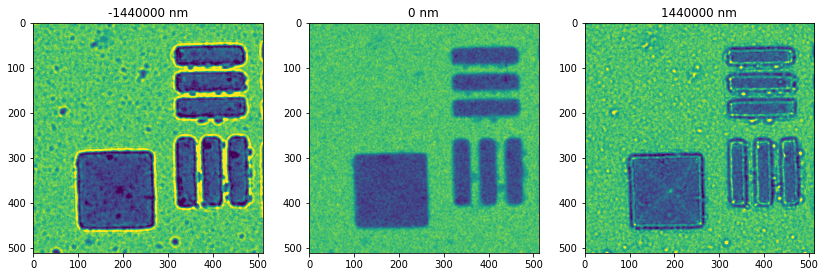

In [ ]:
A_samples = np.zeros((25,512,512))

A_mid = expdata.getframe(12).data[185:697,:512][480-256:480,300-256:300]

for i in range(25):
  A_now = expdata.getframe(i).data[185:697,:512][480-256:480,300-256:300]
  dy, dx = cross_correlation(A_now , A_mid)
  A_now = expdata.getframe(i).data[185:697,:512][480-256+dy:480+dy,300-256+dx:300+dx]
  dy2, dx2 = cross_correlation(A_now , A_mid)
  #print(dy, dx, dy2, dx2)
  if dx>=0:
    A_samples[i] =  expdata.getframe(i).data[185+dy:697+dy,dx:512+dx]
  else:
    A_samples[i,:,dx:] =  expdata.getframe(i).data[185+dy:697+dy,dx:512]

  #A_samples[i] =  expdata.getframe(i).data[185-44:697-44,:512] #2s
  #A_samples[i] =  expdata.getframe(i).data[185:697,:512] #0p2s
  A_samples[i] =  expdata.getframe(i).data[185-13:697-13,:512] #1s

A_samples = np.sqrt(A_samples)
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

defocus = np.array([-1440000,-1210000,-1000000,-810000,-640000,-490000,-360000,-250000,-160000,-90000,-40000,-10000,0,\
                      10000,40000,90000,160000,250000,360000,490000,640000,810000,1000000,1210000,1440000])

f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[12], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[1].set_title("{0} nm".format(defocus[12]))
ax[2].imshow(A_samples[24], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[2].set_title("{0} nm".format(defocus[24]));

In [ ]:
# generate microscopic transfer function

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

from microscopes_fwd import Microscope

defocus = np.array([-1440000,-1210000,-1000000,-810000,-640000,-490000,-360000,-250000,-160000,-90000,-40000,-10000,0,\
                      10000,40000,90000,160000,250000,360000,490000,640000,810000,1000000,1210000,1440000])

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.1e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 6.9 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128)
DampEnvs = np.zeros(A_samples.shape, dtype=np.float64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  chiq = TEM.getChiQ(qq,del_px)
  tf_microscope[i] = np.cos(chiq) - 1j * np.sin(chiq)
  # tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
  DampEnvs[i] =  TEM.getDampEnv(qq, del_px)


Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 10.0MB/s]


In [ ]:
selection = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]
DE = fftshift(DampEnvs[selection], axes=(1,2))

chosen defocus (mm):  [-1.   -0.81 -0.64 -0.49 -0.36 -0.25 -0.16 -0.09 -0.04 -0.01  0.01  0.04
  0.09  0.16  0.25  0.36  0.49  0.64  0.81  1.  ]


In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False)
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(A_samples[12].shape)+0.5

In [ ]:
ObjWave = guess_amplitude * np.exp(1j*guess_phase)

err = []

maxiter = 10000
t1 = time.time()
tol = 1e-9

t1 = time.time()

for i in range(maxiter):

  ImgWave = ifft2(fft2(ObjWave)*TF*DE)
  err.append(((np.abs(ImgWave)/np.abs(ImgWave).mean(1).mean(1)[:,np.newaxis,np.newaxis]-exp_data)**2).mean())
  ImgWave = ImgWave / np.abs(ImgWave) * exp_data
  #          ------  back propagation  -------  weighted sum with DE as weight (only works for small defocus)
  ObjWave = ifft2( (fft2(ImgWave)*np.conj(TF)).sum(0) / DE.sum(0) )
  result_phase = np.angle(ObjWave)
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  if i>10:
    if not i%100:
      print(err[-2]-err[-1])
  ObjWave = guess_amplitude * np.exp(1j*result_phase)

t2=time.time()
err = np.array(err)

print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,i))
print("final err {0}".format(err[-1]))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

-1.4466121402790036e-06
-7.992372167407204e-07
-4.348950749001601e-07
-2.4958890676787804e-07
-1.9158068712216494e-07
-1.7431856669247736e-07
-1.8118323829316788e-07
-1.6662519400833728e-07
-1.8578364941942982e-07
-2.1691838123774274e-07
-2.6094217146993906e-07
-3.2199787456050136e-07
-4.0819909136310603e-07


KeyboardInterrupt: ignored

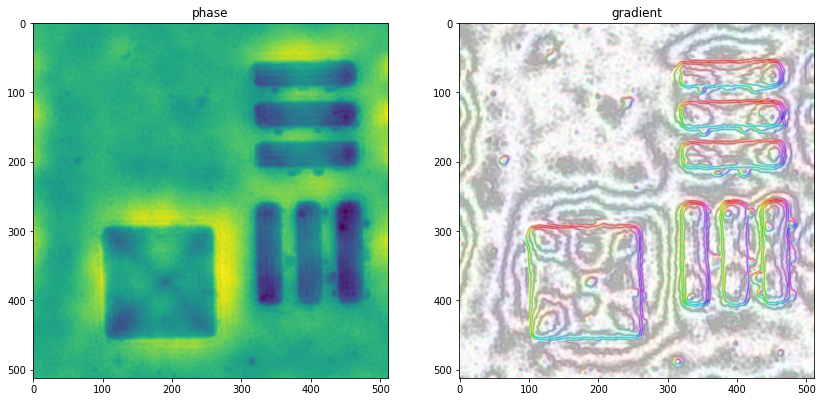

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

ax[0].imshow(result_phase, interpolation='none', cmap='viridis')
ax[0].set_title("phase")

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap='gray', alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("gradient");